# ***Predicting Fake News using the Fake News dataset using Tf-Idf vectorizer and evaluating performance using ROC curves.***

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
import numpy as np
import pandas as pd


# Locate and load the data file
df_true = pd.read_csv('./EP_dataset_TF/True.csv')
df_fake = pd.read_csv('./EP_dataset_TF/Fake.csv')


# Sanity check
print(f'N rows={len(df_true)}, M columns={len(df_true.columns)}')
print(df_true.columns)

print(f'N rows={len(df_fake)}, M columns={len(df_fake.columns)}')
print(df_fake.columns)

N rows=21417, M columns=4
Index(['title', 'text', 'subject', 'date'], dtype='object')
N rows=23481, M columns=4
Index(['title', 'text', 'subject', 'date'], dtype='object')


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer


df_true['class']=0
df_fake['class']=1
df = pd.concat([df_fake, df_true])
df.head

X_vec = TfidfVectorizer(stop_words='english', max_features=50
).fit_transform(df['title'])

In [3]:
X_vec.shape

(44898, 50)

In [4]:
X_vec.dtype

dtype('float64')

In [5]:
# Populate the dataset, cancer column is target variable
y = df.loc[:, df.columns == 'class'].values.ravel()

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Display OP
def annot(opi, _x, _y):
    plt.annotate(f"OP{opi}", xy=(_x, _y), xytext=(.90*_x+.1, .80*_y), arrowprops=dict(facecolor='lightgray', shrink=1))


Now that we have specified all of our annotation methods and prepared our training and labels data, we will begin with our ML learning setup.

Each section contains 3 types of classifiers, and each classifier follows hyperparametric tuning, generating the ROC curve, and then the classifier is evaluated.
The schema follows:

My current work flow is:

1. 70% training, 30% test split. 

2. Loop through all combinations of hyperparameters specified in lists,

3. Create a classifier with said hyperparameter settings

4. Run cross_validation on the training dataset using the sklearn.cross_validate function specifying 10 fold cross validation, and a scoring scheme that allows me to evaluate the tn, fp, fn, and tp of each individual fold.

5. Accuracy, TPR, and FPR, and F1 lists are made using these values in folds, they are then averaged.

6. ROC plot is made with data averaged after cross validation with annotations.

Then following the book (pg.197 k-fold cross-validation):

"Once we have found satisfactory hyperparameter values, we can retrain the model on the complete training dataset and obtain a final performance estimate using the independent test dataset"

7. Tuned model is evaluated after the ROC curve.

By the way, I have tried hundreds of parameters, I just decided to narrow down the search, in case this notebook gets rerun, so I end up plotting all OPs.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Random Forest Classifier**

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate


depth = [2,3,5,10,12]
estimators = [5, 20, 40, 100]

def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn':cm[0,0], 'fp': cm[0, 1],
            'fn':cm[1,0], 'tp': cm[1, 1]}

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.3, random_state=14)

print(f'{"Test Acc":>8s} {"Depth":>11s} {"Estimators":>11s} {"TPR":>6s} {"FPR":>6s} {"F1":>6s}')
FPR, TPR, F1, ACC = [], [], [], []
params = []
for d in depth:
    for e in estimators:
        rf = RandomForestClassifier(n_estimators=e, max_depth=d, random_state=0, n_jobs=4)
        cv_results = cross_validate(rf, X_train, y_train, cv=10, scoring=confusion_matrix_scorer)
        acc, tpr, fpr, f1 = [], [], [], []
        for i in range(len(cv_results['test_tp'])):
            tp = cv_results['test_tp'][i]
            fp = cv_results['test_fp'][i]
            tn = cv_results['test_tn'][i]
            fn = cv_results['test_fn'][i]

            acc += [(tp+tn)/(tp+tn+fp+fn)]
            tpr += [tp/(tp+fn)]  # Pd
            fpr += [fp/(fp+tn)]  # Pf
            
            prec = tp/(tp+fp)
            recall = tp/(tp+fn)
            f1 += [2*prec*recall/(prec+recall)]
        
        ACC += [np.mean(acc)]
        TPR += [np.mean(tpr)]
        FPR += [np.mean(fpr)]
        F1 += [np.mean(f1)]
        params += [(d,e)]        

        print(f'{ACC[-1]:8.3f} {d:11.2f} {e:11.2f} {TPR[-1]:6.3f} {FPR[-1]:6.3f} {F1[-1]:6.3f}')
    

Test Acc       Depth  Estimators    TPR    FPR     F1
   0.743        2.00        5.00  0.641  0.146  0.722
   0.776        2.00       20.00  0.697  0.138  0.764
   0.775        2.00       40.00  0.715  0.160  0.768
   0.785        2.00      100.00  0.704  0.127  0.774
   0.755        3.00        5.00  0.712  0.198  0.752
   0.787        3.00       20.00  0.626  0.037  0.755
   0.781        3.00       40.00  0.697  0.128  0.768
   0.790        3.00      100.00  0.633  0.038  0.760
   0.774        5.00        5.00  0.635  0.073  0.746
   0.787        5.00       20.00  0.625  0.036  0.754
   0.791        5.00       40.00  0.631  0.034  0.759
   0.793        5.00      100.00  0.638  0.038  0.763
   0.794       10.00        5.00  0.642  0.040  0.765
   0.800       10.00       20.00  0.651  0.038  0.773
   0.800       10.00       40.00  0.651  0.036  0.773
   0.803       10.00      100.00  0.660  0.040  0.778
   0.792       12.00        5.00  0.629  0.030  0.760
   0.803       12.00       2

0.6677621741518849 0.04119178325560737 0.7831009132111164 (12, 100)


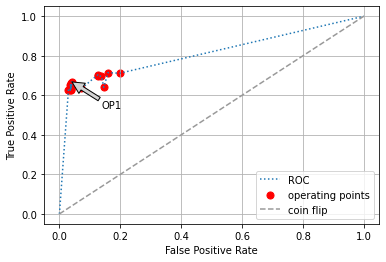

In [8]:
best_F1_Ind = F1.index(max(F1))

print(TPR[best_F1_Ind], FPR[best_F1_Ind],F1[best_F1_Ind], params[best_F1_Ind])

# Sorts the points to display nicely on ROC
FPR_sort, TPR_sort = zip(*sorted(zip(FPR, TPR)))
fpr = [0.]+list(FPR_sort)+[1.]; tpr = [0.]+list(TPR_sort)+[1.]

index_of = TPR_sort.index(TPR[best_F1_Ind])

colors = ['red']*len(FPR_sort)
colors[index_of] = 'blue'

# Plot
fig, ax = plt.subplots(dpi=72)
plt.plot(fpr, tpr, ':', label='ROC')
plt.scatter(FPR_sort, TPR_sort, 50, color='red', marker='o', label='operating points')
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')
annot(1, FPR_sort[index_of], TPR_sort[index_of])


# Labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [9]:
X_train.shape

(31428, 50)

In [10]:
from sklearn.metrics import accuracy_score

final = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=0, n_jobs=4)
final.fit(X_train, y_train)
y_pred = final.predict(X_test)

TRP, FPR, F1 = [], [], []
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
TPR += [tp/(tp+fn)]  # Pd
FPR += [fp/(fp+tn)]  # Pf

prec = tp/(tp+fp)
recall = tp/(tp+fn)
F1 += [2*prec*recall/(prec+recall)]

print(f'{"Test Acc":>8s} {"TPR":>6s} {"FPR":>6s} {"F1":>6s}')
print(f'{accuracy_score(y_test, y_pred):8.3f} {TPR[-1]:6.3f} {FPR[-1]:6.3f}{F1[-1]:6.3f}')

Test Acc    TPR    FPR     F1
   0.804  0.666  0.043 0.781


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Decision Tree Classifier**

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier

info_crit = ["gini", "entropy", "log_loss"]
features = [5, 15, 30]
depth = [3, 10, None]

def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn':cm[0,0], 'fp': cm[0, 1],
            'fn':cm[1,0], 'tp': cm[1, 1]}

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.3, random_state=14)

print(f'{"Test Acc":>8s} {"Criterion":>11s} {"Depth":>11s} {"Features":>11s} {"TPR":>6s} {"FPR":>6s} {"F1":>6s}')
FPR, TPR, F1 = [], [], []
params = []
for i in info_crit:
    for f in features:
        for d in depth:
            rf = DecisionTreeClassifier(criterion=i, max_depth=d, max_features=f, random_state=1)
            cv_results = cross_validate(rf, X_train, y_train, cv=10, scoring=confusion_matrix_scorer)
            acc, tpr, fpr, f1 = [], [], [], []
            for h in range(len(cv_results['test_tp'])):
                tp = cv_results['test_tp'][h]
                fp = cv_results['test_fp'][h]
                tn = cv_results['test_tn'][h]
                fn = cv_results['test_fn'][h]

                acc += [(tp+tn)/(tp+tn+fp+fn)]
                tpr += [tp/(tp+fn)]  # Pd
                fpr += [fp/(fp+tn)]  # Pf

                prec = tp/(tp+fp)
                recall = tp/(tp+fn)
                f1 += [2*prec*recall/(prec+recall)]

            ACC += [np.mean(acc)]
            TPR += [np.mean(tpr)]
            FPR += [np.mean(fpr)]
            F1 += [np.mean(f1)]
            params += [(i,f,d)]
            
            if d==None:
                d=10000
                print(f'{ACC[-1]:8.3f} {i:11} {d:11.2f} {f:11.2f} {TPR[-1]:6.3f} {FPR[-1]:6.3f} {F1[-1]:6.3f}')
            else:
                print(f'{ACC[-1]:8.3f} {i:11} {d:11.2f} {f:11.2f} {TPR[-1]:6.3f} {FPR[-1]:6.3f} {F1[-1]:6.3f}')



Test Acc   Criterion       Depth    Features    TPR    FPR     F1
   0.711 gini               3.00        5.00  0.450  0.003  0.620
   0.744 gini              10.00        5.00  0.519  0.011  0.679
   0.812 gini           10000.00        5.00  0.704  0.070  0.796
   0.683 gini               3.00       15.00  0.397  0.005  0.567
   0.771 gini              10.00       15.00  0.573  0.013  0.723
   0.812 gini           10000.00       15.00  0.703  0.070  0.796
   0.711 gini               3.00       30.00  0.450  0.003  0.620
   0.774 gini              10.00       30.00  0.593  0.029  0.732
   0.813 gini           10000.00       30.00  0.705  0.069  0.797
   0.711 entropy            3.00        5.00  0.450  0.003  0.620
   0.743 entropy           10.00        5.00  0.519  0.010  0.679
   0.813 entropy        10000.00        5.00  0.704  0.068  0.797
   0.679 entropy            3.00       15.00  0.389  0.004  0.558
   0.763 entropy           10.00       15.00  0.564  0.019  0.713
   0.813 e

0.7052032651717729 0.0679208083499889 0.7980342467019657 ('entropy', 30, None)


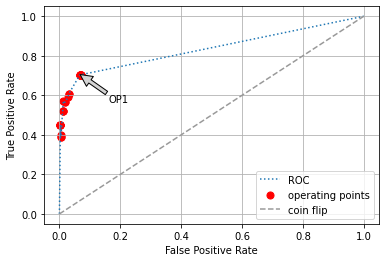

In [12]:
best_F1_Ind = F1.index(max(F1))

print(TPR[best_F1_Ind], FPR[best_F1_Ind],F1[best_F1_Ind], params[best_F1_Ind])

# Sorts the points to display nicely on ROC
FPR_sort, TPR_sort = zip(*sorted(zip(FPR, TPR)))
fpr = [0.]+list(FPR_sort)+[1.]; tpr = [0.]+list(TPR_sort)+[1.]

index_of = TPR_sort.index(TPR[best_F1_Ind])

colors = ['red']*len(FPR_sort)
colors[index_of] = 'blue'

# Plot
fig, ax = plt.subplots(dpi=72)
plt.plot(fpr, tpr, ':', label='ROC')
plt.scatter(FPR_sort, TPR_sort, 50, color='red', marker='o', label='operating points')
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')

annot(1, FPR_sort[index_of], TPR_sort[index_of])

# Labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score

final = DecisionTreeClassifier(criterion='entropy', max_features=30, random_state=1)
final.fit(X_train, y_train)
y_pred = final.predict(X_test)

TRP, FPR, F1 = [], [], []
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
TPR += [tp/(tp+fn)]  # Pd
FPR += [fp/(fp+tn)]  # Pf

prec = tp/(tp+fp)
recall = tp/(tp+fn)
F1 += [2*prec*recall/(prec+recall)]

print(f'{"Test Acc":>8s} {"TPR":>6s} {"FPR":>6s} {"F1":>6s}')
print(f'{accuracy_score(y_test, y_pred):8.3f} {TPR[-1]:6.3f} {FPR[-1]:6.3f}{F1[-1]:6.3f}')

Test Acc    TPR    FPR     F1
   0.815  0.706  0.065 0.800


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Multilayer Neural Network**

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neural_network import MLPClassifier

learning_rate = [0.05, 0.2, 0.4]
layer_size = [(5,), (5,5), (5,10), (20,), (20,5), (20,10)]

def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn':cm[0,0], 'fp': cm[0, 1],
            'fn':cm[1,0], 'tp': cm[1, 1]}

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.3, random_state=14)

print(f'{"Test Acc":>8s} {"learning rate":>11s}{"neurons":>11s}{"layer_size":>11s}{"TPR":>6s} {"FPR":>6s} {"F1":>6s}')
FPR, TPR, F1, ACC= [], [], [], []
params = []
for l in learning_rate:
    for neuron in layer_size:
        rf = MLPClassifier(hidden_layer_sizes= neuron, learning_rate_init= l, random_state=1)
        cv_results = cross_validate(rf, X_train, y_train, cv=10, scoring=confusion_matrix_scorer, n_jobs=4)

        acc, tpr, fpr, f1 = [], [], [], []
        for i in range(len(cv_results['test_tp'])):
            tp = cv_results['test_tp'][i]
            fp = cv_results['test_fp'][i]
            tn = cv_results['test_tn'][i]
            fn = cv_results['test_fn'][i]

            acc += [(tp+tn)/(tp+tn+fp+fn)]
            tpr += [tp/(tp+fn)]  # Pd
            fpr += [fp/(fp+tn)]  # Pf
            
            prec = tp/(tp+fp)
            recall = tp/(tp+fn)
            f1 += [2*prec*recall/(prec+recall)]
        
        ACC += [np.mean(acc)]
        TPR += [np.mean(tpr)]
        FPR += [np.mean(fpr)]
        F1 += [np.mean(f1)]
    
        if len(neuron)<2:
            params += [(l,neuron[0],0)]
            print(f'{ACC[-1]:8.3f} {l:11.6f} {neuron[0]:11.2f} {params[-1][-1]:11.2f}{TPR[-1]:6.3f} {FPR[-1]:6.3f} {F1[-1]:6.3f}')
        else:
            params += [(l,neuron[0],neuron[1])]
            print(f'{ACC[-1]:8.3f} {l:11.6f} {neuron[0]:11.2f} {neuron[1]:11.2f}{TPR[-1]:6.3f} {FPR[-1]:6.3f} {F1[-1]:6.3f}')


        

Test Acc learning rate    neurons layer_size   TPR    FPR     F1
   0.814    0.050000        5.00        0.00 0.702  0.063  0.798
   0.815    0.050000        5.00        5.00 0.702  0.062  0.798
   0.814    0.050000        5.00       10.00 0.710  0.073  0.799
   0.814    0.050000       20.00        0.00 0.716  0.079  0.801
   0.813    0.050000       20.00        5.00 0.694  0.057  0.795
   0.814    0.050000       20.00       10.00 0.702  0.065  0.797
   0.811    0.200000        5.00        0.00 0.694  0.062  0.793
   0.811    0.200000        5.00        5.00 0.692  0.059  0.793
   0.811    0.200000        5.00       10.00 0.691  0.058  0.792
   0.814    0.200000       20.00        0.00 0.700  0.062  0.797
   0.805    0.200000       20.00        5.00 0.731  0.113  0.796
   0.812    0.200000       20.00       10.00 0.699  0.065  0.795
   0.802    0.400000        5.00        0.00 0.669  0.051  0.777
   0.768    0.400000        5.00        5.00 0.750  0.212  0.776
   0.780    0.400000     

0.7159193433478908 0.0788506329113924 0.8007833897569672 (0.05, 20, 0)


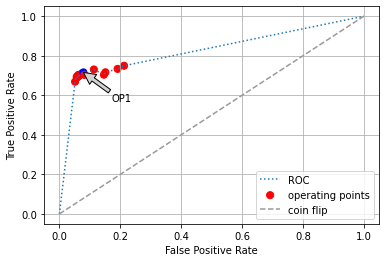

In [15]:
best_F1_Ind = F1.index(max(F1))

print(TPR[best_F1_Ind], FPR[best_F1_Ind],F1[best_F1_Ind], params[best_F1_Ind])

# Sorts the points to display nicely on ROC
FPR_sort, TPR_sort = zip(*sorted(zip(FPR, TPR)))
fpr = [0.]+list(FPR_sort)+[1.]; tpr = [0.]+list(TPR_sort)+[1.]

index_of = TPR_sort.index(TPR[best_F1_Ind])

colors = ['red']*len(FPR_sort)
colors[index_of] = 'blue'



# Plot
fig, ax = plt.subplots(dpi=72)
plt.plot(fpr, tpr, ':', label='ROC')
plt.scatter(FPR_sort, TPR_sort, 50, color=colors, marker='o', label='operating points')
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')

annot(1, FPR_sort[index_of], TPR_sort[index_of])

# Labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [17]:
from sklearn.metrics import accuracy_score

final = MLPClassifier(hidden_layer_sizes= (20,), learning_rate_init= 0.05, random_state=1)
final.fit(X_train, y_train)
y_pred = final.predict(X_test)

TRP, FPR, F1 = [], [], []
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
TPR += [tp/(tp+fn)]  # Pd
FPR += [fp/(fp+tn)]  # Pf

prec = tp/(tp+fp)
recall = tp/(tp+fn)
F1 += [2*prec*recall/(prec+recall)]

print(f'{"Test Acc":>8s} {"TPR":>6s} {"FPR":>6s} {"F1":>6s}')
print(f'{accuracy_score(y_test, y_pred):8.3f} {TPR[-1]:6.3f} {FPR[-1]:6.3f}{F1[-1]:6.3f}')

Test Acc    TPR    FPR     F1
   0.815  0.707  0.067 0.800


**Summary**

So, in total let's compare the best hyperparameters that were selected based on F1 score.

Random Forest: TPR:0.666 FPR:0.043 F1:0.781 Accuracy: 0.804
(Depth:12, Estimators:100)

0.804  0.666  0.043 0.781

Decision Tree: TPR:0.706 FPR:0.065 F1:0.800 Accuracy: 0.815
(Criterion:'entropy', Max_features:30, Cut-off Depth: None)

MLP Neural Network: TPR:0.707 FPR:0.067 F1:0.800 Accuracy: 0.815
(Learning Rate:0.05, neurons: 20, multi-layers:0)


The Neural Network had the greatest success, with marginal returns in increased multilayers or neurons. It's hyperparameter setting achieved the most ideal F1 score, but also the highest TPR, despite a bit of FPR cost. What's noteable is that increased multilayers did not dramatically increase the F1 score and marginal effects on the accuracy.

***What is the exhibited behavior in the Pd – Pf interaction of an ROC
plot, what is the expected behavior?***

TPR and FPR have a direct relationship. As the algorithm attempts to improve TPR it does so at the cost of increased FPR. Classifiers in contrast to random chance, perform better, meaning they are able to achieve a higher TPR while minimizing FPR. The TPR has an optimal value where peak performance is achieved, but then performance mellows out; as we attempt to increase the rate of predicting all positive outcomes, we do so at the cost of increasing the rate of false positives.

Hyper-parameteric tunning tries different variables to attempt to achieve a score that is favorable to the problem at hand. It moves along this ROC curve, and attempts to find the optimal value, the most theoretically optimal value is located at [0,1]. But this value is unachievable unless we train and test on the same dataset, which is a faulty ML design. Instead, different classifiers attempt to push for higher TPR and each have different efficacies. 

Usually problems come with an acceptable FPR threshold, we then aim for classifiers and hyperparameters that attempt to maximize the TPR while maintaining an acceptable FPR. If such thresholds are not available, one can utilize the F1 score. The F1 score relies on precision and recall, and it favors precision slightly over recall. Remember that recall is exactly the same as the TPR, precision is different than FPR. FPR is concerned with the negative class, of the negative class, it cares about the ratio of correctly labeled negative classes (meaning there are no False Positives (no misses)), even if it means having many erroneous False Negatives. Precision cares about the ***accuracy*** of the positive class (meaning there are no False Positives), so long as it accurately describes positive classes, then it doesn't matter if it misses many of them.

Recall works opposite of Precision, as the dataset grows larger, to increase Recall (catch all positive cases), it would mean that we allow some False Positives; this lowers precision. How does this interaction compare against our problem, and which metric should we use?

Remember that we assigned Fake news cases with a value of 1; sklearn classifiers use this value of 1 as the positive case. In the news, news from different sources is valued differently, government sources, CIA, FBI, IRS tend to have more information before informing the public. It's vital that this news is not marked as Fake, so it's really important that we are accurate in what we describe to be the positive. Imagine if we were to report that a natural disaster signal, or danger of an impending nuclear bomb, as fake. We have to be specific in what we mark as Fake (positive), while attempting to catch all the Fake cases. This means we have to prioritize precision.

An excellent metric to use in this case is the F1 score, it combines information of Recall and Precision, while prioritizing Precision. This is my justification for utilizing F1 score, over other metrics.

***From the ROC plot, let's make a selection of the classifier and hyperparameter setting for this problem. Note that we are classifying fake news so your
conclusion might be subjective but has to be supported by our findings.***

As justified by my previous answer, the F1 score is the best metric to choose our classifier and hyperparameters, as it prioritizes precision while incorporating recall. Based on this metric, the MLP classifier had the best F1 score.

It provided a F1 score of 0.800, an Accuracy of 0.815 which was also highest, a TPR score of 0.707, and an FPR score of 0.067. The hyperparameters that resulted in these outcomes were:

A learning rate of 0.05
Layers of size 0
And 20 neurons per layer.

Tuning of this classifier was the most computationally intensive, and it could be argued if the results justify the ~15min added computational time. Depending on the importance of this project/ the size of the ML scheme, including this classifier in our analysis could be justified, especially if maximizing TPR is a priority.

### ***Let's add a text column and use a model to predict our performance:***

In [18]:
from scipy.sparse import hstack
import numpy as np

X_vec1 = TfidfVectorizer(stop_words='english', max_features=50
).fit_transform(df['title'])

print(X_vec1.shape)

X_vec2 = TfidfVectorizer(stop_words='english', max_features=50
).fit_transform(df['text'])

print(X_vec2.shape)

X_vec_comp = hstack((X_vec1, X_vec2), format='csr')
print(X_vec_comp.shape)

(44898, 50)
(44898, 50)
(44898, 100)


In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.naive_bayes import MultinomialNB

alpha = [0.2,0.5, 1, 5, 10, 20, 50, 100, 500, 1000, 5000, 10000]

def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return {'tn':cm[0,0], 'fp': cm[0, 1],
            'fn':cm[1,0], 'tp': cm[1, 1]}

X_train, X_test, y_train, y_test = train_test_split(X_vec_comp, y, test_size=0.3, random_state=14)

print(f'{"Test Acc":>8s} {"alpha":>11s}{"TPR":>6s} {"FPR":>6s} {"F1":>6s}')
FPR, TPR, F1, ACC= [], [], [], []
params = []
for a in alpha:
    rf = MultinomialNB(alpha = a)
    cv_results = cross_validate(rf, X_train, y_train, cv=10, scoring=confusion_matrix_scorer, n_jobs=4)

    acc, tpr, fpr, f1 = [], [], [], []
    for i in range(len(cv_results['test_tp'])):
        tp = cv_results['test_tp'][i]
        fp = cv_results['test_fp'][i]
        tn = cv_results['test_tn'][i]
        fn = cv_results['test_fn'][i]

        acc += [(tp+tn)/(tp+tn+fp+fn)]
        tpr += [tp/(tp+fn)]  # Pd
        fpr += [fp/(fp+tn)]  # Pf

        prec = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1 += [2*prec*recall/(prec+recall)]

    ACC += [np.mean(acc)]
    TPR += [np.mean(tpr)]
    FPR += [np.mean(fpr)]
    F1 += [np.mean(f1)]
    params += [a]

    print(f'{ACC[-1]:8.3f} {a:11.6f}{TPR[-1]:6.3f} {FPR[-1]:6.3f} {F1[-1]:6.3f}')

Test Acc       alpha   TPR    FPR     F1
   0.913    0.200000 0.891  0.063  0.914
   0.913    0.500000 0.891  0.063  0.914
   0.913    1.000000 0.891  0.063  0.914
   0.913    5.000000 0.891  0.063  0.914
   0.913   10.000000 0.891  0.064  0.914
   0.912   20.000000 0.891  0.064  0.914
   0.912   50.000000 0.891  0.065  0.914
   0.911  100.000000 0.889  0.065  0.913
   0.908  500.000000 0.889  0.071  0.910
   0.905 1000.000000 0.893  0.081  0.908
   0.891 5000.000000 0.937  0.160  0.900
   0.854 10000.000000 0.972  0.276  0.874


0.8907154925150291 0.06272107483899622 0.9144898816929807 0.5


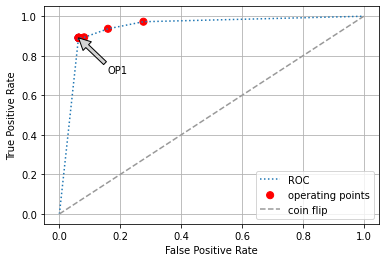

In [20]:
best_F1_Ind = F1.index(max(F1))

print(TPR[best_F1_Ind], FPR[best_F1_Ind],F1[best_F1_Ind], params[best_F1_Ind])

# Sorts the points to display nicely on ROC
FPR_sort, TPR_sort = zip(*sorted(zip(FPR, TPR)))
fpr = [0.]+list(FPR_sort)+[1.]; tpr = [0.]+list(TPR_sort)+[1.]

index_of = TPR_sort.index(TPR[best_F1_Ind])

colors = ['red']*len(FPR_sort)
colors[index_of] = 'blue'



# Plot
fig, ax = plt.subplots(dpi=72)
plt.plot(fpr, tpr, ':', label='ROC')
plt.scatter(FPR_sort, TPR_sort, 50, color=colors, marker='o', label='operating points')
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')

annot(1, FPR_sort[index_of], TPR_sort[index_of])

# Labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [21]:
from sklearn.metrics import accuracy_score

final = MultinomialNB(alpha = 0.5)
final.fit(X_train, y_train)
y_pred = final.predict(X_test)

TRP, FPR, F1 = [], [], []
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
TPR += [tp/(tp+fn)]  # Pd
FPR += [fp/(fp+tn)]  # Pf

prec = tp/(tp+fp)
recall = tp/(tp+fn)
F1 += [2*prec*recall/(prec+recall)]

print(f'{"Test Acc":>8s} {"TPR":>6s} {"FPR":>6s} {"F1":>6s}')
print(f'{accuracy_score(y_test, y_pred):8.3f} {TPR[-1]:6.3f} {FPR[-1]:6.3f}{F1[-1]:6.3f}')

Test Acc    TPR    FPR     F1
   0.908  0.884  0.065 0.910


***Why did our performance increase in comparison to the model using only the title column?***

Our accuracy jumped from a meager 81.4% in the neural network classifier with only the title column in the dataset, to a respectable 90.8% using the Multinomial Naive Bayes classifier and considering the top 50 features of each of the title column and text column. Clearly, adding an extra degree of dimensionality from the titles, advanced our algorithms predictive prowess. Furthermore, our TPR advanced substantially from 0.704 to 0.884 with the same FPR. This indicates a model with a greater Recall in detecting the Fake stories, meaning we are able to substantiate more of the Fake stories. It makes sense that the text can help increase the substantiation of Fake news, note only does it introducing additional dimensionality to the data, but the text data is in itself adds context perhaps even sources which can help discern what is Fake news from Real news. The results indicate that the top 50 words in titles simply didn't have enough data to lead to a good correlation, adding the text helped with this. Despite this problem having a large number of dimensions initially with the titles, one would think it suffers from the curse of Dimensionality, however the nature of the problem is classifying semantics behind Fake news, so the number of features "keywords" that we will likely need, needs to increase appropriately to address the problem. This is a rare instance where increasing the "vocabulary", the dimensions helps the classifier, and certain classifiers tend to behave better than others.